# Example: PyRayHF Generate Oblique Data
This is a modification of [`Example_PyRayHF_Cartesian_Gradient.ipynb`](./Example_PyRayHF_Cartesian_Gradient.ipynb) that simply demonstrates the process of ray tracing on input data obtained from PyIRI and generation of the oblique ionogram.

(see [`Example_Generate_2D_Input.ipynb`](./Example_Generate_2D_Input.ipynb) for generating PyIRI input data for PyRayHF)

1. Imports

In [4]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
import PyRayHF
from copy import deepcopy
import matplotlib.colors as colors
import matplotlib.cm as cm
import pickle

Load Previously Generated EDP

In [5]:
# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create input
# arrays using PyIRI.
file_open = 'MoJo_Oblique_0N_-150E.p'
mojo_oblique = pickle.load(open(file_open, 'rb'))

file_open = 'MoJo_Oblique_Day.p'
mojo_oblique_uniform = pickle.load(open(file_open, 'rb'))

file_open = 'MoJo_Vertical_Day.p'
mojo_vertical = pickle.load(open(file_open, 'rb'))

file_open = 'Example_Input_Day.p'
input_arrays = pickle.load(open(file_open, 'rb'))

file_open = 'Example_Input_2D_Day.p'
input_arrays_2d = pickle.load(open(file_open, 'rb'))

R_loc = 1000.


# uniform case
nrays = len(mojo_oblique_uniform['ray_data_X'])
af0_uniform_Hz = np.zeros(nrays) # Array of ray frequencies
P_uniform = np.zeros(nrays)
for i in range(nrays):
    af0_uniform_Hz[i] = mojo_oblique_uniform["ray_data_X"][i]["freq_Hz"]
    P_uniform[i] = mojo_oblique_uniform["ray_data_X"][i]["delay_km"]

# gradient case
nrays = len(mojo_oblique['ray_data_X'])
af0_Hz = np.zeros(nrays) # Array of ray frequencies
P = np.zeros(nrays)
for i in range(nrays):
    af0_Hz[i] = mojo_oblique["ray_data_X"][i]["freq_Hz"]
    P[i] = mojo_oblique["ray_data_X"][i]["delay_km"]

a_x_apex = np.zeros((nrays))
a_z_apex = np.zeros((nrays))
for i in range(nrays):
    a_x_apex[i] = mojo_oblique['ray_data_X'][i]['x_apex_km']
    a_z_apex[i] = mojo_oblique['ray_data_X'][i]['z_apex_km']

alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)


Plot oblique and vertical at midpoint

/var/folders/hx/vfmrc7fn3cb_5y7fpsjwylcw0000gq/T/ipykernel_8697/3598717254.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.94, 1])  # leave space for colorbar


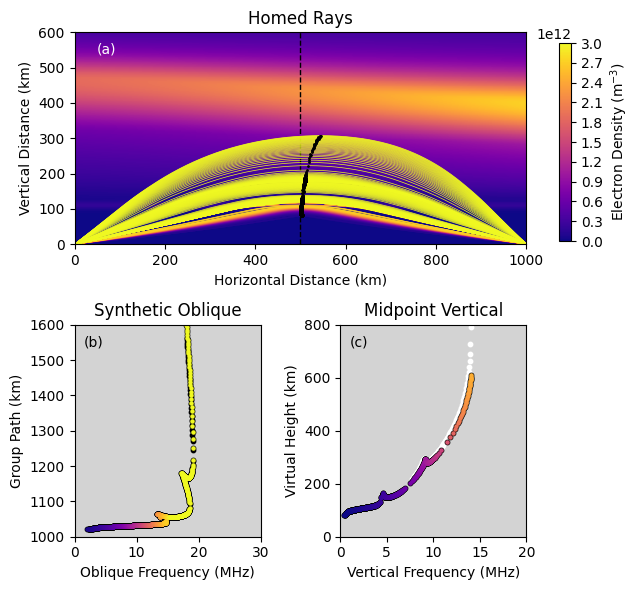

In [6]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
ax_top = fig.add_subplot(gs[0, :])
ax_bot1 = fig.add_subplot(gs[1, 0])
ax_bot2 = fig.add_subplot(gs[1, 1])

# --- Top: Raytracing plot ------------------------------------------------
ax_plot = ax_top
ax_plot.set_xlim(0, 1000)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Distance (km)')
ax_plot.set_xlabel('Horizontal Distance (km)')
ax_plot.set_title("Homed Rays")

vmin, vmax = 0, 3e12
nx = 500
xmax = 1000.
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))


Xg, Zg = np.meshgrid(input_arrays_2d["xgrid"], input_arrays_2d["zgrid"])
Ne_grid = input_arrays_2d["den"]

# Plot Density
pc = ax_plot.pcolormesh(Xg, Zg, Ne_grid, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.axvline(x=R_loc / 2., linestyle='--', color='black', linewidth=1)

cmap = cm.plasma
norm = colors.Normalize(vmin=vmin, vmax=vmax)
af0_den = PyRayHF.library.freq2den(af0_Hz)

for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax_plot.plot(mojo_oblique['ray_data_X'][ifr]['x'][:], mojo_oblique['ray_data_X'][ifr]['z'][:], color=color, linewidth=0.5)

for ifr in range(af0_Hz.size):
    ax_plot.scatter(mojo_oblique['ray_data_X'][ifr]['x_apex_km'], mojo_oblique['ray_data_X'][ifr]['z_apex_km'], color='black', s=1, zorder=2)

ax_plot.text(0.05, 0.95, '(a)', transform=ax_plot.transAxes,
             ha='left', va='top', c='white')

# --- Bottom left: Synthetic Oblique -------------------------------------
ax = ax_bot1
ax.set_title('Synthetic Oblique')
ax.set_facecolor('lightgray')
ax.set_ylabel('Group Path (km)')
ax.set_xlabel('Oblique Frequency (MHz)')
ax.set_xlim([0, 30])
ax.set_ylim([1000, 1600])

# Plot uniform case
f_uniform = af0_uniform_Hz / 1e6
ax.scatter(f_uniform, P_uniform, c='black', s=10)

# Plot gradient case
f = af0_Hz / 1e6
ax.scatter(f, P, c='black', s=10)

for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax.scatter(f[ifr], P[ifr], color=color, s=5)
ax.text(0.05, 0.95, '(b)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Bottom right: Midpoint Vertical ------------------------------------
ax = ax_bot2
ax.set_title('Midpoint Vertical')
ax.set_facecolor('lightgray')
ax.set_ylabel('Virtual Height (km)')
ax.set_xlabel('Vertical Frequency (MHz)')
ax.set_xlim([0, 20])
ax.set_ylim([0, 800])

# Find R_E at the T location
R_E = PyRayHF.library.earth_radius_at_latitude(input_arrays['tlat'])
# Oblique to vertical conversion
freq_vertical_mhz, height_virtual_km = PyRayHF.library.oblique_to_vertical(
    R_loc, P, f, R_E=R_E)

freq_vertical_mhz_den = PyRayHF.library.freq2den(freq_vertical_mhz * 1e6)
ax.scatter(mojo_vertical['afreq_Hz'] / 1e6, mojo_vertical['vh_X_km'], c='white', s=10)
ax.scatter(freq_vertical_mhz, height_virtual_km, c='black', s=10)
for ifr in range(af0_Hz.size):
    color = cmap(norm(freq_vertical_mhz_den[ifr]))
    ax.scatter(freq_vertical_mhz[ifr], height_virtual_km[ifr], color=color, s=5)
ax.text(0.05, 0.95, '(c)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Single shared vertical colorbar on the right ------------------------
cbar_ax = fig.add_axes([0.94, 0.59, 0.02, 0.33])  # x, y, width, height
cbar = fig.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Electron Density (m$^{-3}$)')
cbar.set_ticks(np.arange(vmin, vmax + 3e11, 3e11))

plt.tight_layout(rect=[0, 0, 0.94, 1])  # leave space for colorbar
plt.savefig('../figures/Oblique.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


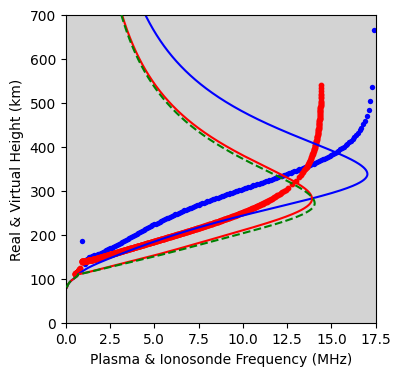

In [ ]:
# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
# Consider this the model background for the upcoming minimization.
mode = 'X'
n_points = 200

vh_data, EDP_truth = PyRayHF.library.model_VH(input_arrays['F2'],
                                              input_arrays['F1'],
                                              input_arrays['E'],
                                              input_arrays['freq'],
                                              input_arrays['alt'],
                                              input_arrays['bmag'],
                                              input_arrays['bpsi'],
                                              mode=mode,
                                              n_points=n_points)

# Create a background by modifying the truth parameters:
F2_back = deepcopy(input_arrays['F2'])
F2_back['Nm'] = F2_back['Nm'] * 1.5
F2_back['hm'] = F2_back['hm'] * 1.2
F2_back['B0'] = F2_back['B0'] * 0.8

# Produce background data, or the observations expected by the background
vh_back, EDP_back = PyRayHF.library.model_VH(F2_back,
                                             input_arrays['F1'],
                                             input_arrays['E'],
                                             input_arrays['freq'],
                                             input_arrays['alt'],
                                             input_arrays['bmag'],
                                             input_arrays['bpsi'],
                                             mode=mode,
                                             n_points=n_points)

# Filter out NaNs in the synthetic data before minimization.
# Minimization will not work properly if NaNs are present.
ind_valid = np.where(np.isfinite(height_virtual_km) == 1)[0]
freq_in = freq_vertical_mhz[ind_valid]  #input_example['freq'][ind_valid]
vh_in = height_virtual_km[ind_valid]

# Using Powell optimization to find F2-layer parameters that best
# reproduce the synthetic virtual height observations.
(vh_result,
 EDP_result) = PyRayHF.library.minimize_parameters(F2_back,
                                                   input_arrays['F1'],
                                                   input_arrays['E'],
                                                   freq_in,
                                                   vh_in,
                                                   input_arrays['alt'],
                                                   input_arrays['bmag'],
                                                   input_arrays['bpsi'],
                                                   method='Powell',
                                                   percent_sigma=20.,
                                                   step=2.,
                                                   mode=mode,
                                                   n_points=n_points)

# Plot the results of the minimization
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 700])
ax.set_xlim([0, 17.5])
ax.set_facecolor('lightgray')
ax.set_ylabel('Real & Virtual Height (km)')
ax.set_xlabel('Plasma & Ionosonde Frequency (MHz)')

ax.plot(PyRayHF.library.den2freq(EDP_back) / 1e6, input_arrays['alt'], c='blue', label='Background', zorder=2)
ax.scatter(input_arrays['freq'], vh_back, c='blue', label='Model Data', zorder=1, linewidth=0, s=15)

ax.plot(PyRayHF.library.den2freq(EDP_truth) / 1e6, input_arrays['alt'], c='red', label='Truth', zorder=2)
ax.scatter(freq_vertical_mhz, height_virtual_km, c='red', s=10, label='MoJo Transformed')

ax.plot(PyRayHF.library.den2freq(EDP_result) / 1e6, input_arrays['alt'], '--', c='green', label='Result', zorder=3)

plt.savefig('../figures/Minimization.png', dpi=300, bbox_inches='tight', facecolor='white')
 